In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [ ]:
# https://www.tensorflow.org/tutorials/load_data/images 
#https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

In [ ]:
print(tf.__version__)
from google.colab import drive
drive.mount('/content/drive') 

2.8.2
Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/nasi'

In [ ]:
batch_size = 32
img_height = 224
img_width = 224




#data_dir = r'C:\nasi'

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height,img_width),
  batch_size=batch_size)


Found 1341 files belonging to 6 classes.
Using 1073 files for training.


In [ ]:
print ((train_ds))

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1341 files belonging to 6 classes.
Using 268 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Nasi briyani', 'Nasi dagang', 'Nasi kerabu', 'Nasi lemuni', 'Nasi minyak', 'Nasi tomato']


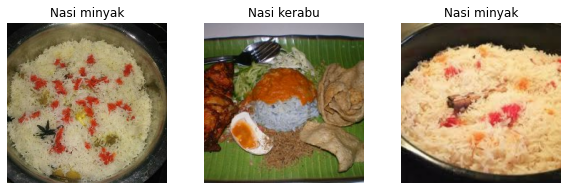

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
#Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011764707 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 6

In [ ]:
#We use Include_top=False to remove the classification layer that was trained on the ImageNet dataset
#and set the model as not trainable or we can set it to trainable.


from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = True ## if Not trainable weights we set it to False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Now we add the last layers for our specific problem.

from tensorflow.keras import layers, models
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
drop_layer = tf.keras.layers.Dropout(.6, )
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


model = models.Sequential([
    data_augmentation,                       
    base_model,
    flatten_layer,
    dense_layer_1,
    drop_layer,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
#from tensorflow.python.client import device_lib 
#print(device_lib.list_local_devices())

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=300
)

Epoch 1/300
 8/34 [======>.......................] - ETA: 7s - loss: 1.6848 - accuracy: 0.2461

KeyboardInterrupt: ignored

In [ ]:
# We try new model that is frozen NOT trainable
from tensorflow.keras.applications.vgg16 import VGG16
#from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model_frozen = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

base_model_frozen.trainable = False
base_model_frozen.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
# Now we add the last layers for our specific problem.

from tensorflow.keras import layers, models
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(180, 180),
  tf.keras.layers.RandomContrast(0.4),                                       
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

model_2 = models.Sequential([
    data_augmentation ,
    base_model_frozen,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=300
)

Epoch 1/300
34/34 [==============================] - 5s 139ms/step - loss: 0.4811 - accuracy: 0.8229 - val_loss: 0.9175 - val_accuracy: 0.7239
Epoch 2/300
34/34 [==============================] - 5s 140ms/step - loss: 0.4938 - accuracy: 0.8164 - val_loss: 0.8098 - val_accuracy: 0.7052
Epoch 3/300
34/34 [==============================] - 5s 142ms/step - loss: 0.4982 - accuracy: 0.8239 - val_loss: 0.9868 - val_accuracy: 0.6679
Epoch 4/300
34/34 [==============================] - 5s 145ms/step - loss: 0.5121 - accuracy: 0.8164 - val_loss: 1.0362 - val_accuracy: 0.6567
Epoch 5/300
34/34 [==============================] - 5s 146ms/step - loss: 0.5361 - accuracy: 0.8155 - val_loss: 0.9330 - val_accuracy: 0.6679
Epoch 6/300
34/34 [==============================] - 5s 147ms/step - loss: 0.5120 - accuracy: 0.8295 - val_loss: 0.9367 - val_accuracy: 0.6791
Epoch 7/300
34/34 [==============================] - 5s 149ms/step - loss: 0.5013 - accuracy: 0.8239 - val_loss: 0.9505 - val_accuracy: 0.6828